# Random Forest: Predicting ENVO Local Scale from Google Earth Embeddings

This notebook trains a Random Forest classifier to predict environmental ontology (ENVO) local scale terms from Google Earth Engine satellite embeddings.

**Question**: Can geographic/satellite imagery data predict environmental classification labels?

## Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Load and Prepare Data

In [2]:
# Load the NMDC complete dataset
df = pd.read_csv('../data/nmdc_flattened_biosample_for_env_embeddings_202510061052_complete.csv')

print(f"Total rows: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Total rows: 8121
Columns: ['accession', 'collection_date', 'latitude', 'longitude', 'env_broad_scale', 'env_local_scale', 'env_medium', 'google_earth_embeddings', 'envo_broad_scale_embedding', 'envo_medium_embedding', 'envo_local_scale_embedding']

First few rows:


,accession,collection_date,latitude,longitude,env_broad_scale,env_local_scale,env_medium,google_earth_embeddings,envo_broad_scale_embedding,envo_medium_embedding,envo_local_scale_embedding
0,nmdc:bsm-11-ywtc8b82,2017-03-07,38.917216,-106.955995,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.08882737408688965, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."
1,nmdc:bsm-11-xcyvst62,2017-03-07,38.917216,-106.955995,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.08882737408688965, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."
2,nmdc:bsm-11-1srsh991,2017-03-07,38.917216,-106.955995,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.08882737408688965, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."
3,nmdc:bsm-11-2nqe9j19,2017-03-07,38.920400,-106.948287,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.06698961937716265, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."
4,nmdc:bsm-11-39j0y956,2017-03-07,38.920400,-106.948287,ENVO:01000177,ENVO:00000292,ENVO:00005802,"[-0.06698961937716265, -0.2364628988850442, -0...","[0.03509042412042618, 0.02636082097887993, 0.0...","[0.028898712247610092, 0.02002768963575363, 0....","[0.014175891876220703, 0.03145849332213402, 0...."


In [3]:
# Check for missing values in key columns
print("Missing values:")
print(df[['google_earth_embeddings', 'env_local_scale']].isna().sum())

# Filter to rows with both embeddings and labels
df_clean = df[df['google_earth_embeddings'].notna() & df['env_local_scale'].notna()].copy()
print(f"\nRows with both Google Earth embeddings and env_local_scale: {len(df_clean)}")

Missing values:
google_earth_embeddings    0
env_local_scale            0
dtype: int64

Rows with both Google Earth embeddings and env_local_scale: 8121


## Parse Embeddings

In [4]:
def parse_embedding(embedding_str):
    """
    Parse embedding string to numpy array.

    Args:
        embedding_str: String representation of embedding list

    Returns:
        numpy array of embedding values
    """
    try:
        if isinstance(embedding_str, str):
            embedding_list = ast.literal_eval(embedding_str)
        else:
            embedding_list = embedding_str
        return np.array(embedding_list, dtype=np.float32)
    except Exception as e:
        print(f"Error parsing embedding: {e}")
        return None

# Parse Google Earth embeddings
print("Parsing Google Earth embeddings...")
df_clean['ge_embedding'] = df_clean['google_earth_embeddings'].apply(parse_embedding)

# Remove any rows where parsing failed
df_clean = df_clean[df_clean['ge_embedding'].notna()].copy()

print(f"Rows with valid embeddings: {len(df_clean)}")
if len(df_clean) > 0:
    embedding_dim = len(df_clean.iloc[0]['ge_embedding'])
    print(f"Google Earth embedding dimension: {embedding_dim}")

Parsing Google Earth embeddings...
Rows with valid embeddings: 8121
Google Earth embedding dimension: 64


## Explore Target Variable

In [5]:
# Examine env_local_scale values
print("=== TARGET VARIABLE: env_local_scale ===")
print(f"\nUnique values: {df_clean['env_local_scale'].nunique()}")
print(f"\nValue counts:")
value_counts = df_clean['env_local_scale'].value_counts()
print(value_counts)

# Show some examples
print(f"\nExample values:")
for val in df_clean['env_local_scale'].unique()[:10]:
    print(f"  - {val}")

=== TARGET VARIABLE: env_local_scale ===

Unique values: 51

Value counts:
env_local_scale
ENVO:00000114    1824
ENVO:01000843    1041
ENVO:01000816     785
ENVO:00000078     696
ENVO:01000888     589
ENVO:01000869     510
ENVO:00000022     281
ENVO:00005801     229
ENVO:00000148     192
ENVO:00000011     177
ENVO:01000893     165
ENVO:00000469     153
ENVO:03600095     142
ENVO:01000855     136
ENVO:01000892     107
ENVO:01001057     100
ENVO:00002131      92
ENVO:03605007      89
ENVO:01000891      88
ENVO:01000861      83
ENVO:01000887      83
ENVO:03600094      75
ENVO:01001442      56
ENVO:00000292      53
ENVO:01000219      42
ENVO:01000621      35
ENVO:01000894      31
ENVO:03600096      31
ENVO:01001206      30
ENVO:03600018      28
ENVO:00000516      19
ENVO:01000409      19
ENVO:00002000      14
ENVO:03600011      14
ENVO:01001191      14
ENVO:01000297      13
ENVO:00000100      12
ENVO:00000021      12
ENVO:00000044      10
ENVO:00002269       9
ENVO:01001357       6
ENVO:01

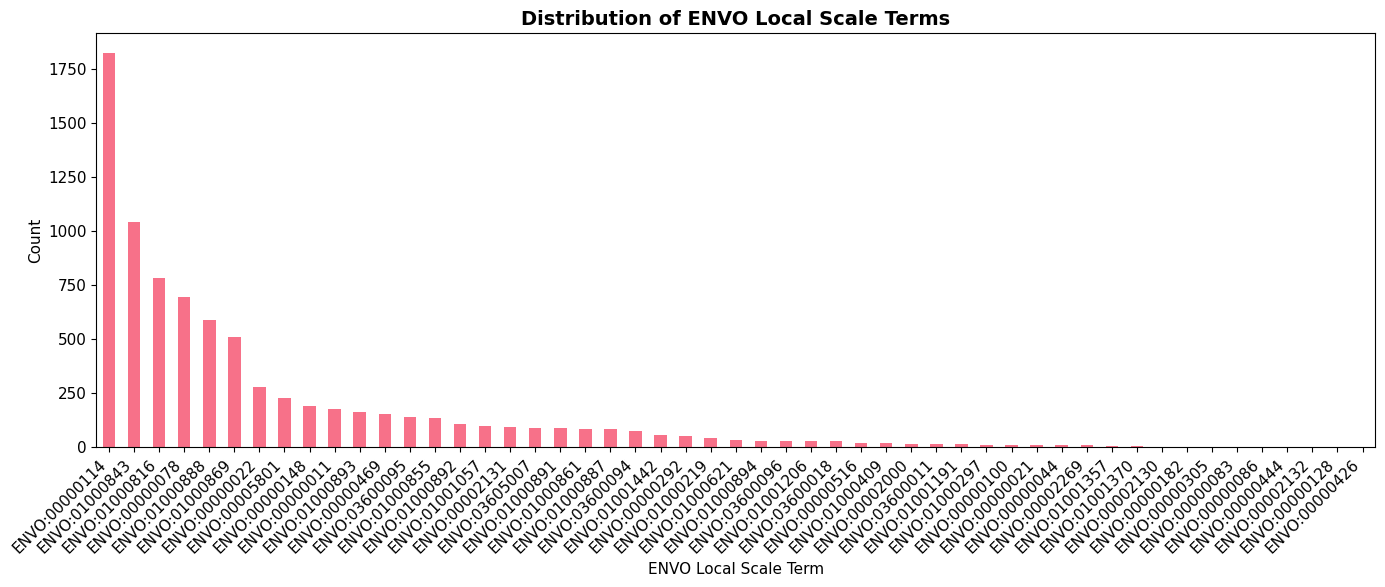


Class balance analysis:
Most common class: 1824 samples (22.5%)
Least common class: 1 samples (0.0%)


In [6]:
# Visualize class distribution
fig, ax = plt.subplots(figsize=(14, 6))
value_counts.plot(kind='bar', ax=ax)
ax.set_title('Distribution of ENVO Local Scale Terms', fontsize=14, fontweight='bold')
ax.set_xlabel('ENVO Local Scale Term')
ax.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nClass balance analysis:")
print(f"Most common class: {value_counts.iloc[0]} samples ({value_counts.iloc[0]/len(df_clean)*100:.1f}%)")
print(f"Least common class: {value_counts.iloc[-1]} samples ({value_counts.iloc[-1]/len(df_clean)*100:.1f}%)")

## Prepare Features and Labels

In [7]:
# Create feature matrix X from embeddings
X = np.vstack(df_clean['ge_embedding'].values)
print(f"Feature matrix shape: {X.shape}")

# Create target vector y
y = df_clean['env_local_scale'].values
print(f"Target vector shape: {y.shape}")

print(f"\nNumber of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

Feature matrix shape: (8121, 64)
Target vector shape: (8121,)

Number of samples: 8121
Number of features: 64
Number of classes: 51


## Train/Test Split

In [8]:
# Determine if stratification is possible
min_class_count = value_counts.min()
use_stratify = min_class_count >= 2  # Need at least 2 samples per class for stratification

print(f"Minimum class count: {min_class_count}")
print(f"Using stratified split: {use_stratify}")

# Split the data
test_size = 0.2
if use_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE, stratify=y
    )
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=RANDOM_STATE
    )

print(f"\nTraining set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())

Minimum class count: 1
Using stratified split: False

Training set: 6496 samples
Test set: 1625 samples

Training set class distribution:
ENVO:00000114    1457
ENVO:01000843     828
ENVO:01000816     629
ENVO:00000078     561
ENVO:01000888     484
ENVO:01000869     397
ENVO:00000022     220
ENVO:00005801     189
ENVO:00000148     159
ENVO:00000011     139
ENVO:01000893     131
ENVO:00000469     124
ENVO:03600095     115
ENVO:01000855     109
ENVO:01000892      84
ENVO:01001057      78
ENVO:01000861      72
ENVO:03605007      70
ENVO:00002131      69
ENVO:01000891      67
ENVO:01000887      64
ENVO:03600094      62
ENVO:01001442      44
ENVO:00000292      43
ENVO:01000219      32
ENVO:01000894      28
ENVO:01000621      28
ENVO:01001206      27
ENVO:03600096      24
ENVO:03600018      22
ENVO:01000409      16
ENVO:00000516      14
ENVO:03600011      12
ENVO:01001191      12
ENVO:00000021      11
ENVO:00000100      10
ENVO:01000297      10
ENVO:00002000       8
ENVO:00000044       8
ENVO

## Train Random Forest Classifier

In [9]:
# Train Random Forest
print("Training Random Forest Classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_classifier.fit(X_train, y_train)
print("Training complete!")

Training Random Forest Classifier...
Training complete!


## Model Evaluation

In [10]:
# Make predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=== MODEL PERFORMANCE ===")
print(f"Training accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")
print(f"\nDifference (overfitting check): {train_accuracy - test_accuracy:.3f}")

=== MODEL PERFORMANCE ===
Training accuracy: 0.928
Test accuracy: 0.886

Difference (overfitting check): 0.042


In [11]:
# Cross-validation on training set
if len(X_train) >= 5:  # Need enough samples for CV
    cv_folds = min(5, len(X_train))
    print(f"\n=== CROSS-VALIDATION ({cv_folds}-fold) ===")
    cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=cv_folds, scoring='accuracy')
    print(f"CV Accuracy scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
else:
    print("\nDataset too small for cross-validation")


=== CROSS-VALIDATION (5-fold) ===
CV Accuracy scores: [0.89461538 0.88221709 0.89222479 0.88221709 0.8860662 ]
Mean CV accuracy: 0.887 (+/- 0.010)


In [12]:
# Detailed classification report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
print(classification_report(y_test, y_test_pred, zero_division=0))


=== CLASSIFICATION REPORT (Test Set) ===
               precision    recall  f1-score   support

ENVO:00000011       0.43      0.34      0.38        38
ENVO:00000021       0.00      0.00      0.00         1
ENVO:00000022       0.90      0.62      0.74        61
ENVO:00000044       1.00      1.00      1.00         2
ENVO:00000078       1.00      1.00      1.00       135
ENVO:00000100       0.00      0.00      0.00         2
ENVO:00000114       1.00      1.00      1.00       367
ENVO:00000128       0.00      0.00      0.00         2
ENVO:00000148       0.57      0.61      0.59        33
ENVO:00000182       0.00      0.00      0.00         1
ENVO:00000292       1.00      1.00      1.00        10
ENVO:00000444       0.00      0.00      0.00         3
ENVO:00000469       1.00      1.00      1.00        29
ENVO:00000516       1.00      1.00      1.00         5
ENVO:00002000       1.00      0.17      0.29         6
ENVO:00002130       0.00      0.00      0.00         0
ENVO:00002131       0.

## Confusion Matrix

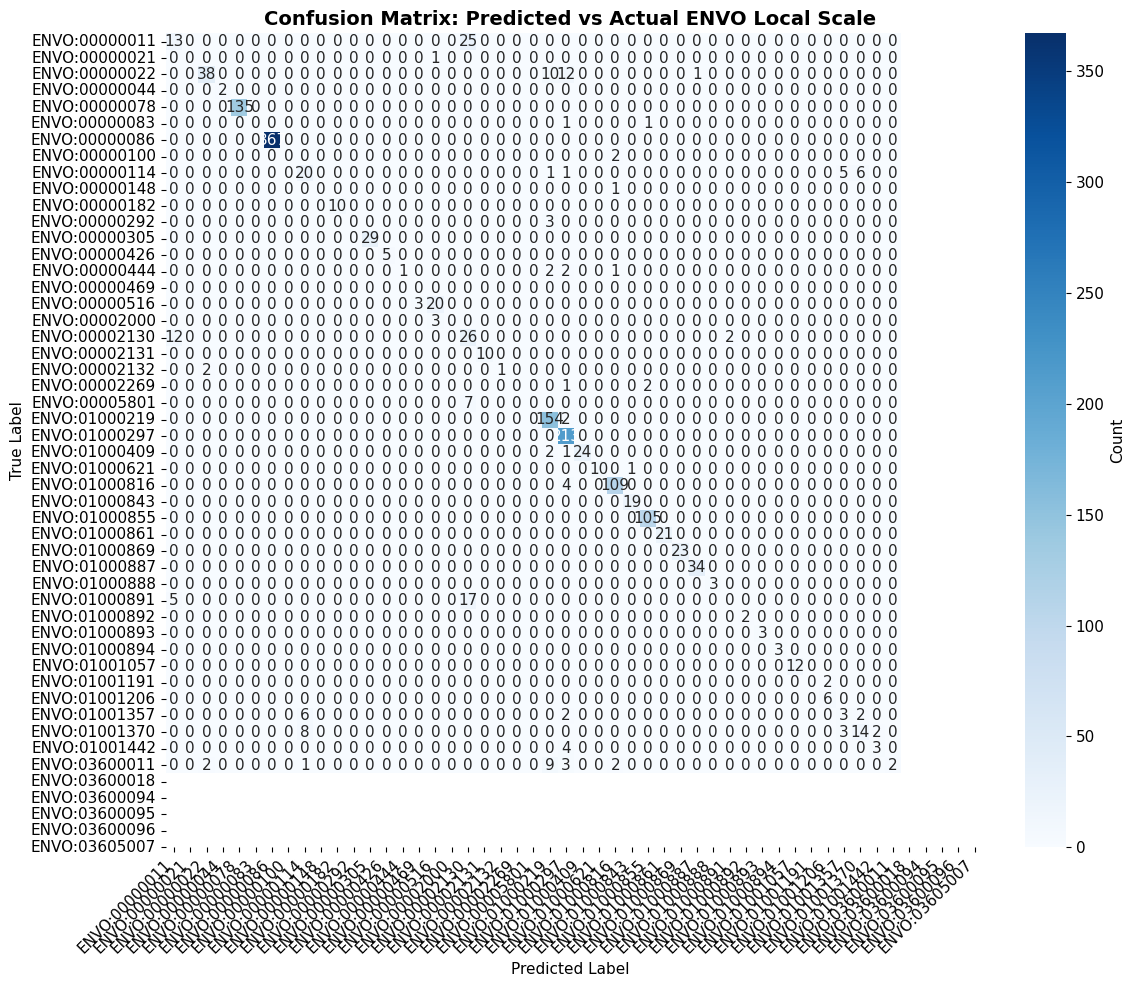

In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
class_labels = rf_classifier.classes_

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix: Predicted vs Actual ENVO Local Scale',
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Feature Importance

In [14]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_
feature_names = [f"GE_dim_{i}" for i in range(len(feature_importances))]

# Sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("=== TOP 20 MOST IMPORTANT FEATURES ===")
print(importance_df.head(20))

=== TOP 20 MOST IMPORTANT FEATURES ===
      feature  importance
39  GE_dim_39    0.051771
14  GE_dim_14    0.047758
28  GE_dim_28    0.032814
29  GE_dim_29    0.032650
34  GE_dim_34    0.031698
21  GE_dim_21    0.031413
45  GE_dim_45    0.031251
11  GE_dim_11    0.030904
46  GE_dim_46    0.024727
18  GE_dim_18    0.024188
19  GE_dim_19    0.022297
24  GE_dim_24    0.022103
37  GE_dim_37    0.021041
30  GE_dim_30    0.019534
16  GE_dim_16    0.018491
33  GE_dim_33    0.018349
48  GE_dim_48    0.018233
51  GE_dim_51    0.018158
35  GE_dim_35    0.018040
50  GE_dim_50    0.016729


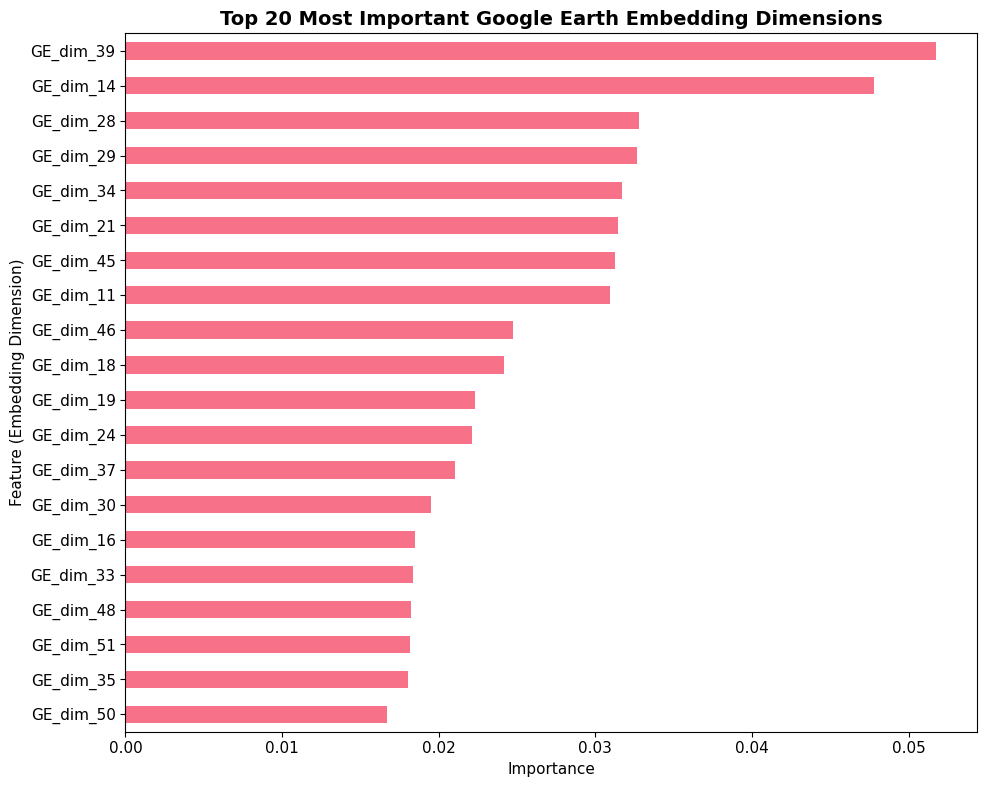

In [15]:
# Plot top 20 feature importances
top_n = 20
fig, ax = plt.subplots(figsize=(10, 8))
importance_df.head(top_n).plot(x='feature', y='importance', kind='barh', ax=ax, legend=False)
ax.set_title(f'Top {top_n} Most Important Google Earth Embedding Dimensions',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature (Embedding Dimension)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## Prediction Analysis

In [16]:
# Get prediction probabilities
y_test_proba = rf_classifier.predict_proba(X_test)
max_probabilities = y_test_proba.max(axis=1)

print("=== PREDICTION CONFIDENCE ===")
print(f"Mean prediction confidence: {max_probabilities.mean():.3f}")
print(f"Std prediction confidence: {max_probabilities.std():.3f}")
print(f"Min prediction confidence: {max_probabilities.min():.3f}")
print(f"Max prediction confidence: {max_probabilities.max():.3f}")

=== PREDICTION CONFIDENCE ===
Mean prediction confidence: 0.770
Std prediction confidence: 0.241
Min prediction confidence: 0.124
Max prediction confidence: 1.000


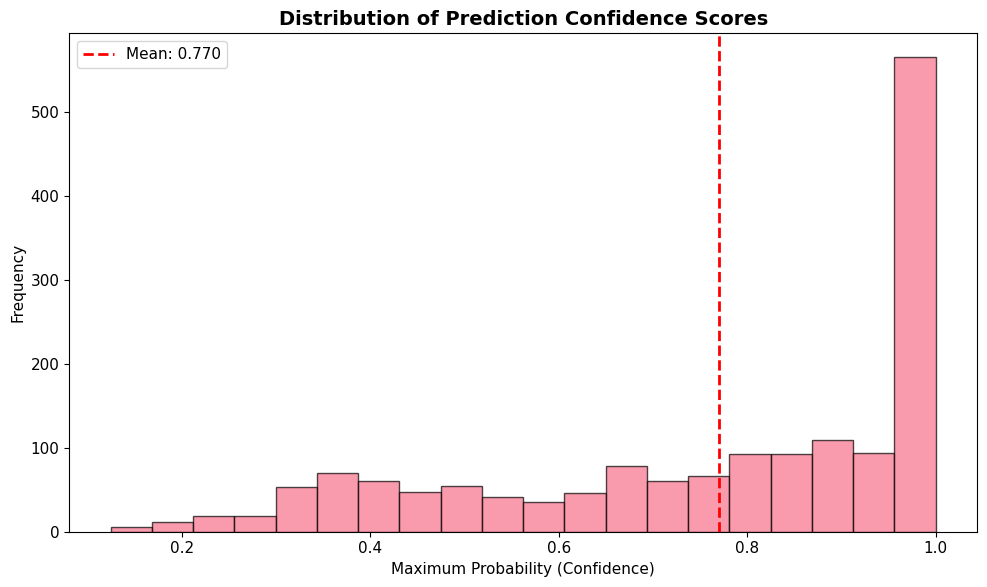

In [17]:
# Plot prediction confidence distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(max_probabilities, bins=20, alpha=0.7, edgecolor='black')
ax.axvline(max_probabilities.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {max_probabilities.mean():.3f}')
ax.set_title('Distribution of Prediction Confidence Scores', fontsize=14, fontweight='bold')
ax.set_xlabel('Maximum Probability (Confidence)')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# Show some example predictions
print("\n=== EXAMPLE PREDICTIONS ===")
n_examples = min(10, len(y_test))
for i in range(n_examples):
    true_label = y_test[i]
    pred_label = y_test_pred[i]
    confidence = max_probabilities[i]
    correct = "✓" if true_label == pred_label else "✗"
    print(f"\n{correct} Sample {i+1}:")
    print(f"  True: {true_label}")
    print(f"  Predicted: {pred_label} (confidence: {confidence:.3f})")


=== EXAMPLE PREDICTIONS ===

✓ Sample 1:
  True: ENVO:00000114
  Predicted: ENVO:00000114 (confidence: 1.000)

✓ Sample 2:
  True: ENVO:01000816
  Predicted: ENVO:01000816 (confidence: 0.827)

✓ Sample 3:
  True: ENVO:01000843
  Predicted: ENVO:01000843 (confidence: 0.792)

✓ Sample 4:
  True: ENVO:00000078
  Predicted: ENVO:00000078 (confidence: 1.000)

✓ Sample 5:
  True: ENVO:01000869
  Predicted: ENVO:01000869 (confidence: 0.964)

✓ Sample 6:
  True: ENVO:01000888
  Predicted: ENVO:01000888 (confidence: 0.969)

✓ Sample 7:
  True: ENVO:01000869
  Predicted: ENVO:01000869 (confidence: 0.949)

✓ Sample 8:
  True: ENVO:00000114
  Predicted: ENVO:00000114 (confidence: 1.000)

✓ Sample 9:
  True: ENVO:01000888
  Predicted: ENVO:01000888 (confidence: 0.967)

✓ Sample 10:
  True: ENVO:00000078
  Predicted: ENVO:00000078 (confidence: 1.000)


## Summary and Conclusions

In [19]:
print("=== EXPERIMENT SUMMARY ===")
print(f"\nDataset:")
print(f"  - Total samples: {len(df_clean)}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Number of classes: {len(np.unique(y))}")
print(f"  - Feature dimensions: {X.shape[1]}")

print(f"\nModel:")
print(f"  - Algorithm: Random Forest Classifier")
print(f"  - Number of trees: {rf_classifier.n_estimators}")
print(f"  - Max depth: {rf_classifier.max_depth}")

print(f"\nPerformance:")
print(f"  - Training accuracy: {train_accuracy:.3f}")
print(f"  - Test accuracy: {test_accuracy:.3f}")
print(f"  - Mean prediction confidence: {max_probabilities.mean():.3f}")

print(f"\nKey Findings:")
if test_accuracy > 0.7:
    print("  ✓ Google Earth embeddings show STRONG predictive power for ENVO local scale")
elif test_accuracy > 0.5:
    print("  ~ Google Earth embeddings show MODERATE predictive power for ENVO local scale")
else:
    print("  ✗ Google Earth embeddings show LIMITED predictive power for ENVO local scale")

if train_accuracy - test_accuracy > 0.2:
    print("  ⚠ Significant overfitting detected - model may not generalize well")
elif train_accuracy - test_accuracy > 0.1:
    print("  ⚠ Moderate overfitting - consider regularization")
else:
    print("  ✓ Good generalization - minimal overfitting")

=== EXPERIMENT SUMMARY ===

Dataset:
  - Total samples: 8121
  - Training samples: 6496
  - Test samples: 1625
  - Number of classes: 51
  - Feature dimensions: 64

Model:
  - Algorithm: Random Forest Classifier
  - Number of trees: 100
  - Max depth: 10

Performance:
  - Training accuracy: 0.928
  - Test accuracy: 0.886
  - Mean prediction confidence: 0.770

Key Findings:
  ✓ Google Earth embeddings show STRONG predictive power for ENVO local scale
  ✓ Good generalization - minimal overfitting
